## In this notbook we will use [NetworkX](https://networkx.org/https://networkx.org/) library to visualize the connection between different characters in the DARK TV series 

# Import necessary libraries 

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import itertools
from itertools import count
import statsmodels.formula.api as smf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['axes.titlesize'] = 30

### Process data into `pandas_edge_list`, described in [here](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html#networkx-convert-matrix-from-pandas-edgelist)
- This will make easy to create graph using pandas dataframe

In [ ]:
with open('../input/dark-netflix-character-relationship/characters.json', 'r') as f:
    data=f.read()
    f.close()
obj = json.loads(data)   

headers = list()
for i in range(len(obj['characters'])):
    headers.extend(list(obj['characters'][i].keys()))
headers = list(set(headers))

dict_1 = {key:[] for key in headers}
for _,character in enumerate(obj['characters']):
    for attribute in list(dict_1.keys()):
        try:
            dict_1[attribute].append(character[attribute])
        except KeyError:
            dict_1[attribute].append(None)

In [ ]:
processed_df = pd.DataFrame.from_dict(dict_1)

In [ ]:
processed_df = processed_df.drop(['firstname','lastname','years','sicMundus'],axis=1)

In [ ]:
rel_heders = ['killedBy','parentOf','married','siblings']

In [ ]:
dict_2 = {'character1':[],'relationship':[],'character2':[]}
for i,row in processed_df.iterrows():
    for rel in rel_heders:
        if row[rel] is not None:
            dict_2['character1'].append(row['name'])
            dict_2['relationship'].append(rel)
            dict_2['character2'].append(row[rel])

In [ ]:
rels_df = pd.DataFrame.from_dict(dict_2)
relationnships_df = rels_df.explode('character2')

properties_df = processed_df[['name','alias','gender']]
properties_df['alias'] = properties_df['alias'].apply(lambda x:x[0] if x is not None else x)

## Define the color map, which we can used in next steps

In [ ]:
color_map = dict({key:'' for key in relationnships_df['relationship'].unique()})
weight_map = dict({key:'' for key in relationnships_df['relationship'].unique()})

In [ ]:
color_map['parentOf'] = 'blue'
color_map['married'] = 'red'
color_map['siblings'] = 'green'
color_map['killedBy'] =  'magenta'

weight_map['parentOf'] = 8
weight_map['married'] = 4
weight_map['siblings'] = 4
weight_map['killedBy'] = 2

In [ ]:
relationnships_df['color'] = relationnships_df['relationship'].map(color_map)
relationnships_df['weight'] = relationnships_df['relationship'].map(weight_map)

In [ ]:
relationnships_df = relationnships_df[['character1','character2','relationship','weight','color']]

In [ ]:
properties_df.to_csv("properties.csv",index=False)
relationnships_df.to_csv("relationnships.csv",index=False)

In [ ]:
relationnships_df.columns = ['source','target','relationship','weight','color']


## Build and plot the Graph

In [ ]:
G = nx.from_pandas_edgelist(
    relationnships_df,
    edge_key="relationship",
    edge_attr=["weight", "color"],
    create_using=nx.DiGraph(),
)
pos = nx.circular_layout(G)
colors = relationnships_df['color']
options = {
    "edge_color": colors,
    "width": 4,
    "edge_cmap": plt.cm.Accent,
    "with_labels": True,
}
plt.figure(figsize=(20,20))
nx.draw(G, pos,node_size=1e3, **options)
patchList = []
for key in color_map:
        data_key = mpatches.Patch(color=color_map[key], label=key)
        patchList.append(data_key)

plt.legend(handles=patchList)
plt.show()
nx.degree(G,weight=None)
nx.pagerank_numpy(G,weight='weight')
nx.degree(G,weight='weight')
nx.betweenness_centrality(G,weight='weight')
nx.transitivity(G)

In [ ]:
def plot_rels(edges,rel,fig_size = (10,10)):
    G = nx.from_pandas_edgelist(
            edges,
            edge_key="relationship",
            edge_attr=["weight", "color"],
            create_using=nx.DiGraph(),
    )
    pos = nx.circular_layout(G)
    colors = edges['color']
    options = {
        "node_color": "#A0CBE2",
        "edge_color": colors,
        'node_size':1e3,
        "width": 4,
        "edge_cmap": plt.cm.Blues,
        "with_labels": True,
    }
    plt.figure(figsize=fig_size)
    nx.draw(G, pos, **options)
    plt.title(f"{rel} Relationships")
    plt.show()

## Plot All relationships

In [ ]:
plot_rels(relationnships_df,'All',(20,20))

 ## Plot individual relationships
 
 ### Married relationship

In [ ]:
plot_rels(relationnships_df.query("relationship=='married'"),'Married',(10,10))

### Plot Parent relationship

In [ ]:
plot_rels(relationnships_df.query("relationship=='parentOf'"),'ParentOf',(10,20))

### Plot Siblings relationship

In [ ]:
plot_rels(relationnships_df.query("relationship=='siblings'"),'Siblings',(10,10))

## When we built a Graph, we can run various Graph Algorithms top of it. 
 - ### Here we are going to use one of most popular Centrality algorithms, [`Betweenness Centrality`](https://neo4j.com/docs/graph-data-science/current/algorithms/betweenness-centrality/#:~:text=Betweenness%20centrality%20is%20a%20way,of%20nodes%20in%20a%20graph.)

In [ ]:
bc = nx.betweenness_centrality(G)
node_colors = list(bc.values())
node_size = [val**2.5 for val in node_colors]
plt.figure(figsize=(20,20))
pos = nx.circular_layout(G)
options = {
    "node_color": node_colors,
    "width": 3,
    "with_labels": True,
    "node_size":node_size
}
nx.draw(G,pos,**options)
plt.show()
deg= nx.degree_centrality(G)
pgr=nx.pagerank_numpy(G,weight='weight')
closeness=nx.closeness_centrality(G)
trans = nx.transitivity(G)


In [ ]:
betweenes_df = pd.DataFrame.from_dict(bc,orient='index').reset_index()
betweenes_df.columns = ['Name','Betweeness Centrality']
betweenes_df.sort_values('Betweeness Centrality',ascending=False)
pagerank_df = pd.DataFrame.from_dict(pgr,orient='index').reset_index()
pagerank_df.columns= ['Name','PageRank Centrality']
pagerank_df.sort_values('PageRank Centrality',ascending=False)
closeness_df=pd.DataFrame.from_dict(closeness,orient='index').reset_index()
closeness_df.columns = ['Name','Closeness Centrality']
closeness_df.sort_values('Closeness Centrality',ascending=False)
degree_df=pd.DataFrame.from_dict(deg,orient='index').reset_index()
degree_df.columns = ['Name','Degree Centrality']
degree_df.sort_values('Degree Centrality',ascending=False)



measures = [pgr, 
            bc,
           deg]
cor = pd.DataFrame.from_records(measures)
cor.T.corr()
cor


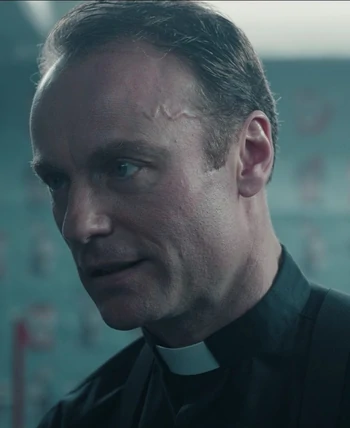

### As per the results shown above most influenctial character in the show !!!
##### PS: I'm not a DARK fan though 😄😄